# **Introduction**

This notebook is for implementing the base SARSA algorithm, an on-policy temporal difference method. Similar to other implementations, this will be done using the Frozen Lake environment offered through Gymnasium. Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API. The `Env` class is leveraged within Gymnasium to encapsulate an environment and the Markov Decision Process (MDP) that runs behind the scenes.

# **Import Packages**

This section imports the necessary packages.

In [333]:
# Import these packages:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

In [334]:
# SARSA-Agent Class:
class SARSA_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self, env: gym.Env, gamma: float, alpha: float, beta: float, es: bool, rs: bool):
        """ 
        this is the constructor for the agent. this agent is a TD-based agent, implementing SARSA, which means that the 
        policy is evaluated and improved every time-step

        env:    a gymnasium environment
        gamma:  a float value indicating the discount factor
        alpha:  a float value indicating the learning rate
        beta:   a float value indicating the decay rate of ε
        es:     a boolean value indicating whether to use exploring starts or not
        rs:     a boolean value indicating whether to use reward shaping or not
                    if true:
                        goal_value: +10.0
                        hole_value: -1.0
                    else:
                        goal_value: +1.0
                        hole_value: 0.0 (sparsely defined)
        Q:      the estimate of the action-value function q, initialized as zeros over all states and actions

        """
        # object parameters:
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.es = es
        self.rs = rs

        # set the reward shaping:
        if self.rs:
            self.goal_value = 10.0
            self.hole_value = -1.0
        else:
            self.goal_value = 1.0
            self.hole_value = 0.0

        # get the number of states, number of actions:
        nS, nA = env.observation_space.n, env.action_space.n

        # get the terminal spaces of the current map:
        desc = env.unwrapped.desc.astype("U1")
        chars = desc.flatten()
        self.terminal_states = [i for i, c in enumerate(chars) if c in ("H", "G")]

        # tabular Q-values:
        self.Q = np.zeros((nS, nA))

        # return to the user the metrics about the environment:
        print(f"Action Space is: {env.action_space}")
        print(f"Observation Space is: {env.observation_space}")

    ####################### TRAINING #######################
    # function to perform ε-greedy probability assignment
    def get_action_probs(self, Q):
        """ 
        this function does the ε-greedy probability assignment for the actions available in a given state

        Q:          a np.ndarray corresponding to the action-values of the actions available in a given state
        returns:    probability of selecting each action

        """
        # get the number of available actions:
        m = len(Q)

        # assign each action a base probability of ε/m
        p = np.ones(m)*(self.epsilon/m)

        # find the index of the best Q value
        best = np.argmax(Q)

        # give that one more probability by an amount equal to (1 - ε):
        p[best] += 1.0 - self.epsilon

        # this way the "best" action has a probability of ε/m + (1-ε), meaning it will be chosen more often
        # whereas the others have a probability of ε/m, so there is a probability that exploratory actions will be selected

        # return the probability of selecting each action:
        return p

    # ε-greedy policy function:
    def policy(self, state):
        """ 
        this is the ε-greedy policy itself, where it chooses an action based on the ε-greedy probabilities of each action

        state:      an int representing the current state
        returns:    a randomly selected action

        """
        probs = self.get_action_probs(self.Q[state])    # for a given state, or row in Q
        return np.random.choice(len(probs), p = probs)  # pick an action from the probabilities of each action

    # GPI function using SARSA rule and ε-greedy policy:
    def GPI(self, num_episodes):
        """
        this function performs the generalized policy iteration using SARSA as the evaluation modality and
        ε-greedy policy improvement to improve the policy

        num_episodes:   number of desired episodes to train the agent on
        returns:        the updated Q values

        """
        for k in tqdm(range(num_episodes)):
            # decay ε:
            self.epsilon = 1.0 / (self.beta*k + 1)

            # if exploring starts:
            if self.es:
                non_terminals = [s for s in range(self.env.observation_space.n) if s not in self.terminal_states]
                starting_state = np.random.choice(non_terminals)

                # force env into starting state:
                _, _ = self.env.reset()
                self.env.unwrapped.s = starting_state
                obs = starting_state
            else:
                obs, _ = self.env.reset()
            
            # take an initial ε-greedy action:
            action = self.policy(obs)

            # flag for finishing
            done = False

            while not done:
                next_obs, r, term, trunc, _ = self.env.step(action)     # take an action, get a new state and a reward
                next_action = self.policy(next_obs)                     # pick next action based on ε-greedy policy

                # if reward shaping:
                if self.rs:
                    if term and r == 0:
                        r = self.hole_value     # fell in a hole
                    elif term and r == 1:
                        r = self.goal_value     # reached goal

                # update Q using SARSA update rule:
                self.Q[obs, action] += self.alpha * (r + self.gamma*self.Q[next_obs, next_action] - self.Q[obs, action])

                # advance state and action indices:
                obs, action = next_obs, next_action

                # check for completion:
                done = term or trunc

        return self.Q
                


# **Using the Environment**

This section utilizes the above object-oriented approach to create an environment and train an agent.

In [335]:
# create training environment:
env = gym.make("FrozenLake-v1", is_slippery = False, render_mode = 'rgb_array')

# instantiate the agent:
agent = SARSA_Agent(env = env, gamma = 0.99, alpha = 1e-3, beta = 5e-4, es = False, rs = True)
num_episodes = 200000

# learn value function using SARSA:
q = agent.GPI(num_episodes = num_episodes).round(3)

Action Space is: Discrete(4)
Observation Space is: Discrete(16)


100%|██████████| 200000/200000 [00:20<00:00, 9816.05it/s] 


# **Visualize the Learned Policy**

This section visualizes the final policy that was learned and overlays a heatmap of the action-value  function $Q(s,a)$.

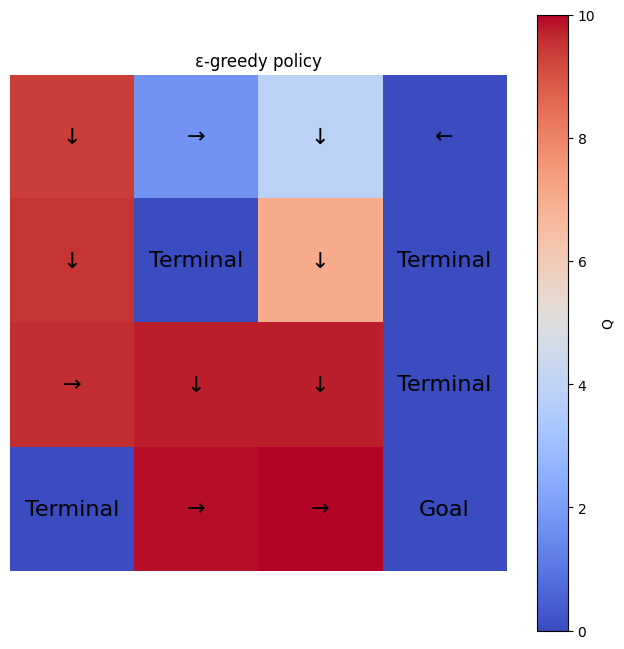

In [336]:
# define mapping of actions to directions:
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑', 4: 'Terminal', 5 : 'Goal'}
size = int(np.sqrt(agent.env.observation_space.n))
grid = np.zeros(agent.env.observation_space.n, dtype = object)

# for every state:
for s in range(agent.env.observation_space.n):
    if s in agent.terminal_states:
        if s == 15:
            action = 5
        else:
            action = 4
    else:
        action = np.argmax(q[s, :])

    grid[s] = action_map[action]

# reshape to look like map:
grid = grid.reshape(size, size)

# plot stuff:
fig, ax = plt.subplots(figsize = (2*size, 2*size))

# heatmap stuff:
heatmap_value = np.max(q, axis = 1).reshape((4,4))
heatmap = ax.imshow(heatmap_value, cmap = 'coolwarm', interpolation = 'nearest')

# overlay text:
for i in range(size):
    for j in range(size):
        text = grid[i, j]
        ax.text(j, i, text, ha = 'center', va = 'center', color = 'black', fontsize = 16)

# formatting:
fig.colorbar(heatmap, ax = ax, label = 'Q')
ax.set_title('ε-greedy policy')
ax.axis('off')

plt.show()